Heston price and variance paths saved to CSV files.


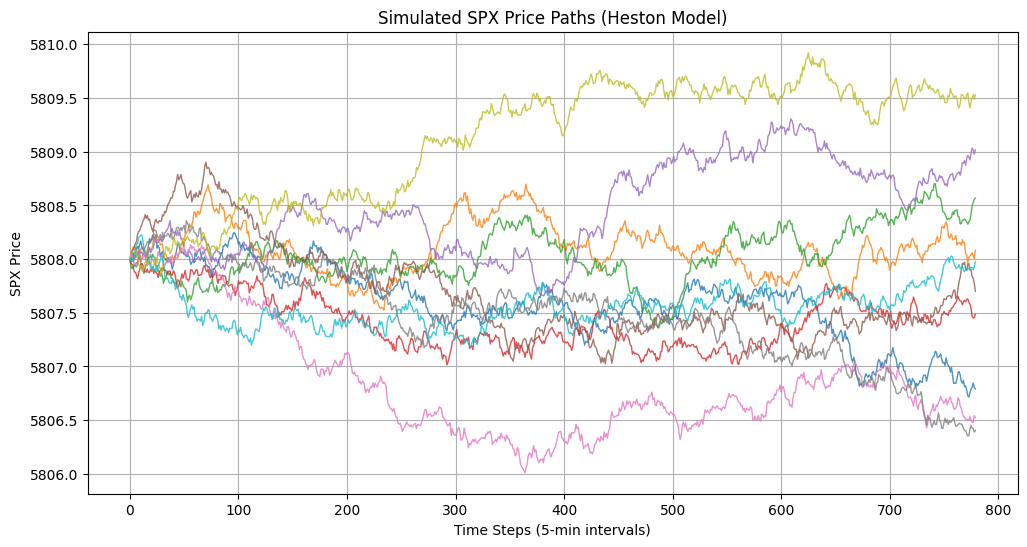

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spx_data= pd.read_csv("enhanced_spx_data.csv")



# Heston model parameters
S0 = spx_data['Adj Close'].iloc[-1]

rolling_volatility = spx_data['returns'].rolling(window=78).std()  # 1-day rolling volatility
v0 = (rolling_volatility.iloc[-1]) ** 2  # Variance is the square of the volatility

mu = spx_data['returns'].mean()

from sklearn.linear_model import LinearRegression
import numpy as np

# Calculate variance
spx_data['variance'] = spx_data['returns'].rolling(window=78).std() ** 2

# Prepare lagged variance and variance change
spx_data['variance_lagged'] = spx_data['variance'].shift(1)
spx_data['variance_change'] = spx_data['variance'] - spx_data['variance_lagged']

# Drop NaN values
data = spx_data.dropna(subset=['variance', 'variance_lagged', 'variance_change'])

# Regression
X = -data['variance_lagged'].values.reshape(-1, 1)  # Lagged variance
y = data['variance_change'].values  # Change in variance
model = LinearRegression().fit(X, y)

kappa = -model.coef_[0]**2  # Speed of mean reversion



# Long-term variance 
theta = model.intercept_ / kappa

# Volatility of volatility
residuals = y - model.predict(X)  # Residuals of the regression
sigma_v = np.std(residuals)

# Correlation between asset and variance
# Log returns and variance changes
spx_data['log_returns'] = np.log(spx_data['Adj Close']).diff()
correlation = spx_data['log_returns'].corr(spx_data['variance_change'])
rho = correlation


# Simulation parameters
num_steps = 10 * 78  # 10 days, 78 intervals per day (5-minute intervals)
num_simulations = 22000  # Number of simulated paths
dt = 1 / (252 * 78)  # 5-minute step in years (252 trading days)

# Arrays to store simulated paths
S_paths = np.zeros((num_steps, num_simulations))
v_paths = np.zeros((num_steps, num_simulations))

# Initial conditions
S_paths[0, :] = S0
v_paths[0, :] = v0

# Simulate paths
for t in range(1, num_steps):
    # Generate two correlated Brownian motions
    Z1 = np.random.normal(0, 1, num_simulations)
    Z2 = np.random.normal(0, 1, num_simulations)
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2  # Correlated Brownian motion

    # Update variance (v_t)
    v_prev = v_paths[t - 1, :]
    v_next = v_prev + kappa * (theta - v_prev) * dt + sigma_v * np.sqrt(np.maximum(v_prev, 0)) * np.sqrt(dt) * W2
    v_paths[t, :] = np.maximum(v_next, 0)  # Ensure variance is non-negative

    # Update asset price (S_t)
    S_prev = S_paths[t - 1, :]
    S_next = S_prev * np.exp((mu - 0.5 * v_prev) * dt + np.sqrt(v_prev) * np.sqrt(dt) * W1)
    S_paths[t, :] = S_next

# Convert to DataFrame for analysis
S_df = pd.DataFrame(S_paths)
v_df = pd.DataFrame(v_paths)

# Save to CSV
# S_df.to_csv("heston_price_paths.csv", index=False)
# v_df.to_csv("heston_variance_paths.csv", index=False)

print("Heston price and variance paths saved to CSV files.")

# Plot first 10 simulated price paths
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(S_df[i], lw=1, alpha=0.8)

plt.xlabel('Time Steps (5-min intervals)')
plt.ylabel('SPX Price')
plt.title('Simulated SPX Price Paths (Heston Model)')
plt.grid()
plt.show()
